# Imports

In [28]:
import torch
import random
import os
import requests, zipfile, tarfile

import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from pytorch_pretrained_biggan import BigGAN
from pytorch_pretrained_biggan import one_hot_from_names
from pytorch_pretrained_biggan import truncated_noise_sample

from tqdm.notebook import tqdm, trange

import ipywidgets as widgets       # interactive display
from ipywidgets import interact, IntSlider, FloatSlider, interact_manual, fixed
from ipywidgets import FloatLogSlider, HBox, Layout, VBox, interactive, Label
from ipywidgets import interactive_output, Dropdown

# Helper functions

In [12]:
def image_moments(image_batches, n_batches=None):
    """
    Compute mean an covariance of all pixels from batches of images
    """
    m1, m2 = torch.zeros((), device=DEVICE), torch.zeros((), device=DEVICE)
    n = 0
    for im in tqdm(image_batches, total=n_batches, leave=False,
                 desc='Computing pixel mean and covariance...'):
        im = im.to(DEVICE)
        b = im.size()[0]
        im = im.view(b, -1)
        m1 = m1 + im.sum(dim=0)
        m2 = m2 + (im.view(b,-1,1) * im.view(b,1,-1)).sum(dim=0)
        n += b
    m1, m2 = m1/n, m2/n
    cov = m2 - m1.view(-1,1)*m1.view(1,-1)
    return m1.cpu(), cov.cpu()


def interpolate(A, B, num_interps):
    if A.shape != B.shape:
        raise ValueError('A and B must have the same shape to interpolate.')
    alphas = np.linspace(0, 1, num_interps)
    return np.array([(1-a)*A + a*B for a in alphas])


def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]

    This uses mu_p = 0 and sigma_p = 1, which simplifies the log(p(zs)) term to
    just -1/2*(zs**2)
    """
    b, n, k = zs.size()
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs**2)
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))


def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))


def pca_encoder_decoder(mu, cov, k):
    """
    Compute encoder and decoder matrices for PCA dimensionality reduction
    """
    mu = mu.view(1,-1)
    u, s, v = torch.svd_lowrank(cov, q=k)
    W_encode = v / torch.sqrt(s)
    W_decode = u * torch.sqrt(s)

    def pca_encode(x):
        # Encoder: subtract mean image and project onto top K eigenvectors of
        # the data covariance
        return (x.view(-1,mu.numel()) - mu) @ W_encode

    def pca_decode(h):
        # Decoder: un-project then add back in the mean
        return (h @ W_decode.T) + mu

    return pca_encode, pca_decode


def cout(x, layer):
    """Unnecessarily complicated but complete way to
    calculate the output depth, height and width size for a Conv2D layer

    Args:
    x (tuple): input size (depth, height, width)
    layer (nn.Conv2d): the Conv2D layer

    returns:
    (int): output shape as given in [Ref]

    Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    """
    assert isinstance(layer, nn.Conv2d)
    p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
    k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
    d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
    s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
    in_depth, in_height, in_width = x
    out_depth = layer.out_channels
    out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
    out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
    return (out_depth, out_height, out_width)

In [13]:
def plot_gen_samples_ppca(therm1, therm2, therm_data_sim):
    plt.plot(therm1, therm2, '.', c='c', label='training data')
    plt.plot(therm_data_sim[0], therm_data_sim[1], '.', c='m', label='"generated" data')
    plt.axis('equal')
    plt.xlabel('Thermometer 1 ($^\circ$C)')
    plt.ylabel('Thermometer 2 ($^\circ$C)')
    plt.legend()
    plt.show()


def plot_linear_ae(lin_losses):
    plt.figure()
    plt.plot(lin_losses)
    plt.ylim([0, 2*torch.as_tensor(lin_losses).median()])
    plt.xlabel('Training batch')
    plt.ylabel('MSE Loss')
    plt.show()


def plot_conv_ae(lin_losses, conv_losses):
    plt.figure()
    plt.plot(lin_losses)
    plt.plot(conv_losses)
    plt.legend(['Lin AE', 'Conv AE'])
    plt.xlabel('Training batch')
    plt.ylabel('MSE Loss')
    plt.ylim([0,
            2*max(torch.as_tensor(conv_losses).median(),
                  torch.as_tensor(lin_losses).median())])
    plt.show()


def plot_images(images, h=3, w=3, plt_title=''):
    plt.figure(figsize=(h*2, w*2))
    plt.suptitle(plt_title, y=1.03)
    for i in range(h*w):
        plt.subplot(h, w, i + 1)
        plot_torch_image(images[i])
    plt.axis('off')
    plt.show()


def plot_phi(phi, num=4):
    plt.figure(figsize=(12, 3))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.scatter(zs[i, :, 0], zs[i, :, 1], marker='.')
        th = torch.linspace(0, 6.28318, 100)
        x, y = torch.cos(th), torch.sin(th)
        # Draw 2-sigma contours
        plt.plot(
            2*x*phi[i, 2].exp().item() + phi[i, 0].item(),
            2*y*phi[i, 2].exp().item() + phi[i, 1].item()
            )
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.grid()
        plt.axis('equal')
    plt.suptitle('If rsample() is correct, then most but not all points should lie in the circles')
    plt.show()


def plot_torch_image(image, ax=None):
    ax = ax if ax is not None else plt.gca()
    c, h, w = image.size()
    if c==1:
        cm = 'gray'
    else:
        cm = None

    # Torch images have shape (channels, height, width) but matplotlib expects
    # (height, width, channels) or just (height,width) when grayscale
    im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
    ax.imshow(im_plt, cmap=cm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [14]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

In [15]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [50]:
ld_true = [-7.0066e-01, -2.6368e-01, -2.4250e+00, -2.0247e+00, -1.1795e+00,
        -4.5558e-01, -7.1316e-01, -1.0932e-01, -7.8608e-01, -4.5838e-01,
        -1.0530e+00, -9.1201e-01, -3.8020e+00, -1.7787e+00, -1.2246e+00,
        -6.5677e-01, -3.6001e-01, -2.2313e-01, -1.8262e+00, -1.2649e+00,
        -3.8330e-01, -8.8619e-02, -9.2357e-01, -1.3450e-01, -8.6891e-01,
        -5.9257e-01, -4.8415e-02, -3.3197e+00, -1.6862e+00, -9.8506e-01,
        -1.1871e+00, -7.0422e-02, -1.7378e+00, -1.3099e+00, -1.8926e+00,
        -3.4508e+00, -1.5696e+00, -7.2787e-02, -3.2420e-01, -2.9795e-01,
        -6.4189e-01, -1.4120e+00, -5.3684e-01, -3.4066e+00, -1.9753e+00,
        -1.4178e+00, -2.0399e-01, -2.3173e-01, -1.2792e+00, -7.2990e-01,
        -1.9872e-01, -2.9378e-03, -3.5890e-01, -5.6643e-01, -1.8003e-01,
        -1.5818e+00, -5.2227e-01, -2.1862e+00, -1.8743e+00, -1.4200e+00,
        -3.1988e-01, -3.5513e-01, -1.5905e+00, -4.2916e-01, -2.5556e-01,
        -8.2807e-01, -6.5568e-01, -4.8475e-01, -2.1049e-01, -2.0104e-02,
        -2.1655e+00, -1.1496e+00, -3.6168e-01, -8.9624e-02, -6.7098e-02,
        -6.0623e-02, -5.1165e-01, -2.7302e+00, -6.0514e-01, -1.6756e+00,
        -3.3807e+00, -5.7368e-02, -1.2763e-01, -6.6959e+00, -5.2157e-01,
        -8.7762e-01, -8.7295e-01, -1.3052e+00, -3.6777e-01, -1.5904e+00,
        -3.8083e-01, -2.8388e-01, -1.5323e-01, -3.7549e-01, -5.2722e+00,
        -1.7393e+00, -2.8814e-01, -5.0310e-01, -2.2077e+00, -1.5507e+00,
        -6.8569e-01, -1.4620e+00, -9.2639e-02, -1.4160e-01, -3.6734e-01,
        -1.0053e+00, -6.7353e-01, -2.2676e+00, -6.0812e-01, -1.0005e+00,
        -4.2908e-01, -5.1369e-01, -2.2579e-02, -1.8496e-01, -3.4798e-01,
        -7.3089e-01, -1.1962e+00, -1.6095e+00, -1.7558e-01, -3.3166e-01,
        -1.1445e+00, -2.4674e+00, -5.0600e-01, -2.0727e+00, -5.4371e-01,
        -8.0499e-01, -3.0521e+00, -3.6835e-02, -2.0485e-01, -4.6747e-01,
        -3.6399e-01, -2.6883e+00, -1.9348e-01, -3.1448e-01, -1.6332e-01,
        -3.2233e-02, -2.3336e-01, -2.6564e+00, -1.2841e+00, -1.3561e+00,
        -7.4717e-01, -2.7926e-01, -8.7849e-01, -3.3715e-02, -1.4933e-01,
        -2.7738e-01, -1.6899e+00, -1.5758e+00, -3.2608e-01, -6.5770e-01,
        -1.7136e+00, -5.8316e+00, -1.1988e+00, -8.3828e-01, -1.8033e+00,
        -2.3017e-01, -8.9936e-01, -1.1917e-01, -1.6659e-01, -2.7669e-01,
        -1.2955e+00, -1.2076e+00, -2.2793e-01, -1.0528e+00, -1.4894e+00,
        -5.7428e-01, -7.3208e-01, -9.5673e-01, -1.6617e+00, -3.9169e+00,
        -1.2182e-01, -3.8092e-01, -1.1924e+00, -2.4566e+00, -2.7350e+00,
        -2.8332e+00, -9.1506e-01, -6.7432e-02, -7.8965e-01, -2.0727e-01,
        -3.4615e-02, -2.8868e+00, -2.1218e+00, -1.2368e-03, -9.0038e-01,
        -5.3746e-01, -5.4080e-01, -3.1625e-01, -1.1786e+00, -2.2797e-01,
        -1.1498e+00, -1.3978e+00, -1.9515e+00, -1.1614e+00, -5.1456e-03,
        -1.9316e-01, -1.3849e+00, -9.2799e-01, -1.1649e-01, -2.3837e-01]


def plotting_ld(ld, true=ld_true):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot([-6, 1], [-6, 1], label="Ground Truth")
    ax.scatter(true, ld, marker="x",
             label="Your implementation")
    ax.set_xlabel("Loss from oracle implementation")
    ax.set_ylabel("Loss from your implementation")
    ax.legend()
    ax.set_title("Discriminator Loss")
    plt.show()


lg_true = [-7.0066e-01, -2.6368e-01, -2.4250e+00, -2.0247e+00, -1.1795e+00,
        -4.5558e-01, -7.1316e-01, -1.0932e-01, -7.8608e-01, -4.5838e-01,
        -1.0530e+00, -9.1201e-01, -3.8020e+00, -1.7787e+00, -1.2246e+00,
        -6.5677e-01, -3.6001e-01, -2.2313e-01, -1.8262e+00, -1.2649e+00,
        -3.8330e-01, -8.8619e-02, -9.2357e-01, -1.3450e-01, -8.6891e-01,
        -5.9257e-01, -4.8415e-02, -3.3197e+00, -1.6862e+00, -9.8506e-01,
        -1.1871e+00, -7.0422e-02, -1.7378e+00, -1.3099e+00, -1.8926e+00,
        -3.4508e+00, -1.5696e+00, -7.2787e-02, -3.2420e-01, -2.9795e-01,
        -6.4189e-01, -1.4120e+00, -5.3684e-01, -3.4066e+00, -1.9753e+00,
        -1.4178e+00, -2.0399e-01, -2.3173e-01, -1.2792e+00, -7.2990e-01,
        -1.9872e-01, -2.9378e-03, -3.5890e-01, -5.6643e-01, -1.8003e-01,
        -1.5818e+00, -5.2227e-01, -2.1862e+00, -1.8743e+00, -1.4200e+00,
        -3.1988e-01, -3.5513e-01, -1.5905e+00, -4.2916e-01, -2.5556e-01,
        -8.2807e-01, -6.5568e-01, -4.8475e-01, -2.1049e-01, -2.0104e-02,
        -2.1655e+00, -1.1496e+00, -3.6168e-01, -8.9624e-02, -6.7098e-02,
        -6.0623e-02, -5.1165e-01, -2.7302e+00, -6.0514e-01, -1.6756e+00,
        -3.3807e+00, -5.7368e-02, -1.2763e-01, -6.6959e+00, -5.2157e-01,
        -8.7762e-01, -8.7295e-01, -1.3052e+00, -3.6777e-01, -1.5904e+00,
        -3.8083e-01, -2.8388e-01, -1.5323e-01, -3.7549e-01, -5.2722e+00,
        -1.7393e+00, -2.8814e-01, -5.0310e-01, -2.2077e+00, -1.5507e+00]


def plotting_lg(lg, true=lg_true):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot([-6, 1], [-6, 1], label="Ground Truth")
    ax.scatter(true, lg, marker="x",
             label="Your implementation")
    ax.set_xlabel("Loss from oracle implementation")
    ax.set_ylabel("Loss from your implementation")
    ax.legend()
    ax.set_title("Generator loss")
    plt.show()

# Download data

In [16]:
fname = 'wordnet.zip'
url = 'https://osf.io/ekjxy/download'
r = requests.get(url, allow_redirects=True)

with open('wordnet.zip', 'wb') as fd:
    fd.write(r.content)

# Variational Autoencoders (VAEs)

## Generating Images from BigGAN

In [17]:
# download bigGan
url = "https://osf.io/3yvhw/download"
fname = "biggan_deep_256"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fd:
    fd.write(r.content)

biggan_model = torch.load(fname)

To demonstrate the power of generative models, we are giving you a sneak peek of a fully trained generative model called BigGAN. You’ll see it again (with more background under your belt) later today. For now, let’s just focus on BigGAN as a generative model. Specifically, BigGAN is a class conditional generative model for 128 x 128 images. The classes are based on categorical labels that describe the images and images are generated based upon a vector (z from the video lecture) and the probability that the image comes from a specific discrete category.

For now, don’t worry about the specifics of the model other than the fact that it generates images based on the vector and the category label.

To explore the space of generated images, we’ve provided you with a widget that allows you to select a category label and to alter the value of the vector. The vector is a 128-D, which may seem high dimensional, but is much lower-dimensional than a 128 x 128 image! To simplify usability the widget limits the magnitude of the vector and constrains all entries to be equal (so you are only exploring a subset of the possible images that can be generated).

In [27]:
def sample_from_biggan(category, z_magnitude):
    unit_vector = np.ones((1, 128))/np.sqrt(128)
    z = z_magnitude * unit_vector
    y = one_hot_from_names(category, batch_size=1)

    z = torch.from_numpy(z)
    z = z.float()
    y = torch.from_numpy(y)

    # Move to GPU
    z = z.to(device=set_device())
    y = y.to(device=set_device())
    biggan_model.to(device=set_device())

    with torch.no_grad():
        output = biggan_model(z, y, 1)

    # Back to CPU
    output = output.to('cpu')

    # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
    # Therefore, we normalize the images properly to [0, 1] range.
    # Clipping is only in case of numerical instability problems

    output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)

    plt.imshow(torch.movedim(output.squeeze(), 0, -1))
    plt.axis('off')

z_slider = IntSlider(min=-15, max=15, step=1, value=0,
                     continuous_update=False,
                     description='Z Magnitude',
                     layout=Layout(width='440px'))

category_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
             value="German shepherd",
             description="Category: ")

widgets_ui = VBox([category_dropdown, z_slider])

widgets_out = interactive_output(sample_from_biggan,
                                 {
                                     'z_magnitude': z_slider,
                                  'category': category_dropdown
                                  }
                                 )

display(widgets_ui, widgets_out)

Output()

## Interpolating Images with BigGAN

In [29]:
def interpolate_biggan(category_A, z_magnitude_A, category_B, z_magnitude_B):
    num_interps = 16

    # category_A = 'jellyfish' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
    # z_magnitude_A = 0 #@param {type:"slider", min:-10, max:10, step:1}

    # category_B = 'German shepherd' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
    # z_magnitude_B = 0 #@param {type:"slider", min:-10, max:10, step:1}


    def interpolate_and_shape(A, B, num_interps):
        interps = interpolate(A, B, num_interps)
        return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                  .reshape(num_interps, *interps.shape[2:]))

    unit_vector = np.ones((1, 128))/np.sqrt(128)
    z_A = z_magnitude_A * unit_vector
    z_B = z_magnitude_B * unit_vector
    y_A = one_hot_from_names(category_A, batch_size=1)
    y_B = one_hot_from_names(category_B, batch_size=1)

    z_interp = interpolate_and_shape(z_A, z_B, num_interps)
    y_interp = interpolate_and_shape(y_A, y_B, num_interps)

    # Convert to tensor
    z_interp = torch.from_numpy(z_interp)
    z_interp = z_interp.float()
    y_interp = torch.from_numpy(y_interp)

    # Move to GPU
    z_interp = z_interp.to(DEVICE)
    y_interp = y_interp.to(DEVICE)
    biggan_model.to(DEVICE)

    with torch.no_grad():
        output = biggan_model(z_interp, y_interp, 1)

    # Back to CPU
    output = output.to('cpu')

    # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
    # Therefore, we normalize the images properly to [0, 1] range.
    # Clipping is only in case of numerical instability problems

    output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
    output = output

    # Make grid and show generated samples
    output_grid = torchvision.utils.make_grid(output,
                                            nrow=min(4, output.shape[0]),
                                            padding=5)
    plt.axis('off');
    plt.imshow(output_grid.permute(1, 2, 0))
    plt.show()


z_A_slider = IntSlider(min=-10, max=10, step=1, value=0,
                        continuous_update=False, description='Z Magnitude A',
                        layout=Layout(width='440px'), style={'description_width': 'initial'})

z_B_slider = IntSlider(min=-10, max=10, step=1, value=0,
                        continuous_update=False, description='Z Magntude B',
                        layout=Layout(width='440px'), style={'description_width': 'initial'})

category_A_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
                      value="German shepherd", description="Category A: ")

category_B_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
                      value="jellyfish", description="Category B: ")



widgets_ui = VBox([HBox([category_A_dropdown, z_A_slider]),
                   HBox([category_B_dropdown, z_B_slider])])

widgets_out = interactive_output(interpolate_biggan,
                                 {'category_A': category_A_dropdown,
                                  'z_magnitude_A': z_A_slider,
                                  'category_B': category_B_dropdown,
                                  'z_magnitude_B': z_B_slider})

display(widgets_ui, widgets_out)

Output()

## Autoencoders

Now we'll create our first autoencoder. It will reduce images down to $K$ dimensions. The architecture will be quite simple: the input will be linearly mapped to a single hidden (or latent) layer $\mathbf{h}$ with $K$ units, which will then be linearly mapped back to an output that is the same size as the input:

\begin{equation}
\mathbf{x} \longrightarrow \mathbf{h} \longrightarrow \mathbf{x'}
\end{equation}

The loss function we'll use will simply be mean squared error (MSE) quantifying how well the reconstruction ($\mathbf{x'}$) matches the original image ($\mathbf{x}$):

\begin{equation}
\text{MSE Loss} = \sum_{i=1}^{N} ||\mathbf{x}_i - \mathbf{x'}_i||^2_2
\end{equation}

If all goes well, then the AutoEncoder will learn, **end to end**, a good "encoding" or "compression" of inputs to a latent representation ($\mathbf{x \longrightarrow h}$) as well as a good "decoding" of that latent representation to a reconstruction of the original input ($\mathbf{h \longrightarrow x'}$).

## Nonlinear Convolutional Autoencoder

**Nonlinear:** We'd like to apply autoencoders to learn a more flexible nonlinear mapping between the latent space and the images. Such a mapping can provide a more "expressive" model that better describes the image data than a linear mapping. This can be achieved by adding nonlinear activation functions to our encoder and decoder!

**Convolutional:** As you saw on the day dedicated to RNNs and CNNs, parameter sharing is often a good idea for images! It's quite common to use convolutional layers in autoencoders to share parameters across locations in the image.

**Side Note:** The `nn.Linear` layer (used in the linear autoencoder above) has a "bias" term, which is a learnable offset parameter separate for each output unit. Just like PCA "centers" the data by subtracting off the mean image (`mu`) before encoding and adds the average back in during decoding, a bias term in the decoder can effectively account for the first moment (mean) of the data (i.e. the average of all images in the training set). Convolution layers do have bias parameters, but the bias is applied per filter rather than per pixel location. If we're generating grayscale images (like those in MNIST), then `Conv2d` will learn only one bias across the entire image.

For some conceptual continuity with both PCA and the `nn.Linear` layers above, the next block defines a custom `BiasLayer` for adding a learnable per-pixel offset. This custom layer will be used twice: as the first stage of the encoder and as the final stage of the decoder. Ideally, this means that the rest of the neural net can focus on fitting more interesting fine-grained structure.

In [42]:
class BiasLayer(nn.Module):
    def __init__(self, shape):
        super(BiasLayer, self).__init__()
        init_bias = torch.zeros(shape)
        self.bias = nn.Parameter(init_bias, requires_grad=True)

    def forward(self, x):
        return x + self.bias

With that out of the way, we will next define a **nonlinear** and **convolutional** autoencoder. Here's a quick tour of the architecture:

1. The **encoder** once again maps from images to $\mathbf{h}\in\mathbb{R}^K$. This will use a `BiasLayer` followed by two convolutional layers (`nn.Conv2D`), followed by flattening and linearly projecting down to $K$ dimensions. The convolutional layers will have `ReLU` nonlinearities on their outputs. 
1. The **decoder** inverts this process, taking in vectors of length $K$ and outputting images. Roughly speaking, its architecture is a "mirror image" of the encoder: the first decoder layer is linear, followed by two **deconvolution** layers ([`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)). The `ConvTranspose2d`layers will have `ReLU` nonlinearities on their _inputs_. This "mirror image" between the encoder and decoder is a useful and near-ubiquitous convention. The idea is that the decoder can then learn to approximately invert the encoder, but it is not a strict requirement (and it does not guarantee the decoder will be an exact inverse of the encoder!).

Below is a schematic of the architecture for MNIST. Notice that the width and height dimensions of the image planes reduce after each `nn.Conv2d` and increase after each `nn.ConvTranspose2d`. With CIFAR10, the architecture is the same but the exact sizes will differ.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D5_GenerativeModels/static/conv_sizes.png">

In [43]:
dummy_image = torch.rand(data_shape).unsqueeze(0)
in_channels = data_shape[0]
out_channels = 7

dummy_conv = nn.Conv2d(in_channels=in_channels,
                       out_channels=out_channels,
                       kernel_size=5)

dummy_deconv = nn.ConvTranspose2d(in_channels=out_channels,
                                  out_channels=in_channels,
                                  kernel_size=5)

print(f'Size of image is {dummy_image.shape}')
print(f'Size of Conv2D(image) {dummy_conv(dummy_image).shape}')
print(f'Size of ConvTranspose2D(Conv2D(image)) {dummy_deconv(dummy_conv(dummy_image)).shape}')

Size of image is torch.Size([1, 1, 28, 28])
Size of Conv2D(image) torch.Size([1, 7, 24, 24])
Size of ConvTranspose2D(Conv2D(image)) torch.Size([1, 1, 28, 28])


In [44]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
        """A Convolutional AutoEncoder

        Args:
          x_dim (tuple): input dimensions (channels, height, widths)
          h_dim (int): hidden dimension, bottleneck dimension, K
          n_filters (int): number of filters (number of output channels)
          filter_size (int): kernel size
        """
        super().__init__()
        channels, height, widths = x_dim

        # encoder input bias layer
        self.enc_bias = BiasLayer(x_dim)

        # first encoder conv2d layer
        self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

        # output shape of the first encoder conv2d layer given x_dim input
        conv_1_shape = cout(x_dim, self.enc_conv_1)

        # second encoder conv2d layer
        self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

        # output shape of the second encoder conv2d layer given conv_1_shape input
        conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

        # The bottleneck is a dense layer, therefore we need a flattenning layer
        self.enc_flatten = nn.Flatten()

        # conv output shape is (depth, height, width), so the flatten size is:
        flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

        # encoder Linear layer
        self.enc_lin = nn.Linear(flat_after_conv, h_dim)

        # decoder Linear layer
        self.dec_lin = nn.Linear(h_dim, flat_after_conv)

        # unflatten data to (depth, height, width) shape
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

        # first "deconvolution" layer
        self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

        # second "deconvolution" layer
        self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

        # decoder output bias layer
        self.dec_bias = BiasLayer(x_dim)

    def encode(self, x):
        s = self.enc_bias(x)
        s = F.relu(self.enc_conv_1(s))
        s = F.relu(self.enc_conv_2(s))
        s = self.enc_flatten(s)
        h = self.enc_lin(s)
        return h

    def decode(self, h):
        s = F.relu(self.dec_lin(h))
        s = self.dec_unflatten(s)
        s = F.relu(self.dec_deconv_1(s))
        s = self.dec_deconv_2(s)
        x_prime = self.dec_bias(s)
        return x_prime

    def forward(self, x):
        return self.decode(self.encode(x))

## Variational Autoencoders

*Recognition models and density networks*


Variational AutoEncoders (VAEs) are a lot like the classic AutoEncoders (AEs), but where we explicitly think about probability distributions. In the language of VAEs, the __encoder__ is replaced with a __recognition model__, and the __decoder__ is replaced with a __density network__.

Where in a classic autoencoder the encoder maps from images to a single hidden vector,

\begin{equation}
\mathbf{x} \overset{\text{AE}}{\longrightarrow} \mathbf{h} \, ,
\end{equation}

in a VAE we would say that a recognition model maps from inputs to entire __distributions__ over hidden vectors,

\begin{equation}
\mathbf{x} \overset{\text{VAE}}{\longrightarrow} q_{\mathbf{w_e}}(\mathbf{z}) \, ,
\end{equation}

which we will then sample from. Here $\mathbf{w_e}$ refers to the weights of the recognition model, which parametarize our distribution generating network. We'll say more in a moment about what kind of distribution $q_{\mathbf{w_e}}(\mathbf{z})$ is.
Part of what makes VAEs work is that the loss function will require good reconstructions of the input not just for a single $\mathbf{z}$, but _on average_ from samples of $\mathbf{z} \sim q_{\mathbf{w_e}}(\mathbf{z})$.

In the classic autoencoder, we had a decoder which maps from hidden vectors to reconstructions of the input:

\begin{equation}
\mathbf{h} \overset{\text{AE}}{\longrightarrow} \mathbf{x'} \, .
\end{equation}

In a density network, reconstructions are expressed in terms of a distribution:

\begin{equation}
\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})
\end{equation}

where, as above, $p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})$ is defined by mapping $\mathbf{z}$ through a density network then treating the resulting $f(\mathbf{z};\mathbf{w_d})$ as the mean of a (Gaussian) distribution over $\mathbf{x}$. Similarly, our reconstruction distribution is parametarized by the weights of the density network.

If we isolate the decoder part of the AutoEncoder, what we have is a neural network that takes as input a vector of size $K$ and produces as output an image that looks something like our training data. Recall that in our earlier notation, we had an input $\mathbf{x}$ that was mapped to a low-dimensional hidden representation $\mathbf{h}$ which was then decoded into a reconstruction of the input, $\mathbf{x'}$:

\begin{equation}
\mathbf{x} \overset{\text{encode}}{\longrightarrow} \mathbf{h} \overset{\text{decode}}{\longrightarrow} \mathbf{x'}\, .
\end{equation}

Partly as a matter of convention, and partly to distinguish where we are going next from the previous section, we're going to introduce a new variable, $\mathbf{z} \in \mathbb{R}^K$, which will take the place of $\mathbf{h}$. The key difference is that while $\mathbf{h}$ is produced by the encoder for a particular $\mathbf{x}$, $\mathbf{z}$ will be drawn out of thin air from a prior of our choosing:

\begin{equation}
\mathbf{z} \sim p(\mathbf{z})\\ \mathbf{z} \overset{\text{decode}}{\longrightarrow} \mathbf{x}\, .
\end{equation}

(Note that it is also common convention to drop the "prime" on $\mathbf{x}$ when it is no longer being thought of as a "reconstruction").

# Generative Adversarial Network (GAN) Models

GANs consist two networks: A critic or discriminator (`disc`) and a generator (`gen`) that are trained by alternating between the following two steps:
- In step 1, we update the parameters (`disc.params`) of the discriminator by backpropagating through the discriminator loss (BCE loss) `disc.loss`.
- In step 2, we update the parameters (`gen.params`) of the generator by backpropagating through the generator loss, `gen.loss` (-1 * BCE loss).

We will now implement a simple GAN training loop!

In [46]:
def get_data():
    return "get_data"


class Disc:

    def loss(self, x_real, x_fake):
        assert x_real == "get_data" and x_fake == "gen.sample", "Inputs to disc.loss is wrong"

    def classify(self, x):
        return "disc.classify"


class Gen:

    def loss(self, x_fake, disc_fn):
        assert x_fake == "gen.sample" and disc_fn(None) == "disc.classify", "Inputs to gen.loss is wrong"

    def sample(self, num_samples):
        return "gen.sample"


def backprop(loss, model):
    pass


def update(model, grad):
    pass

In [47]:
def train_gan_iter(data, disc, gen):
    """Update the discriminator (`disc`) and the generator (`gen`) using `data`
    Args:
    data (ndarray): An array of shape (N,) that contains the data
    disc (Disc): The discriminator
    gen (Gen): The generator
    Returns:
    """

    # Number of samples in the data batch
    num_samples = 200

    # The data is the real samples
    x_real = data

    ## Discriminator training

    # Ask the generator to generate some fake samples
    x_fake = gen.sample(num_samples)

    # Compute the discriminator loss
    disc_loss = disc.loss(x_real, x_fake)

    # Compute the gradient for discriminator
    disc_grad = backprop(disc_loss, disc)

    # Update the discriminator
    update(disc, disc_grad)

    ## Generator training

    # Ask the generator to generate some fake samples
    x_fake = gen.sample(num_samples)

    # Compute the generator loss
    gen_loss = gen.loss(x_fake, disc.classify)

    # Compute the gradient for generator
    gen_grad = backprop(gen_loss, gen)

    # Update the generator
    update(gen, gen_grad)

    print("Your implementation passes the check!")

    return None

data = get_data()
disc = Disc()
gen = Gen()
train_gan_iter(data, disc, gen)

Your implementation passes the check!


## GAN Training Objective

### Discriminator Loss

The critic or the discriminator in a vanilla GAN is trained as a binary classifier using the BCE criteria. In this section, we will implement the training objective for the discriminator. 

\begin{equation}
\text{BCE}_\omega = \mathbb{E}_{x \sim p}[\log(\sigma(D_\omega(x)))] + \mathbb{E}_{x \sim q}[\log(1 - \sigma(D_\omega(x)))]
\end{equation}

Here, $p$ is the data distribution and $q$ is the generator distribution. $D_\omega$ is the logit, which represents $\log \frac{p}{q}$. $\sigma$ is the sigmoid function and therfore, $\sigma(D_\omega)$ represents $\frac{p}{p+q}$.

In [48]:
def get_data(num_samples=100, seed=0):
    set_seed(seed)
    return torch.randn([num_samples, 1])


class DummyGen:
    def sample(self, num_samples=100, seed=1):
        set_seed(seed)
        return torch.randn([num_samples, 1]) + 2


class DummyDisc:
    def classify(self, x, seed=0):
        set_seed(seed)
        return torch.rand([x.shape[0], ])

Random seed 0 has been set.
Random seed 1 has been set.
Random seed 0 has been set.
Random seed 0 has been set.


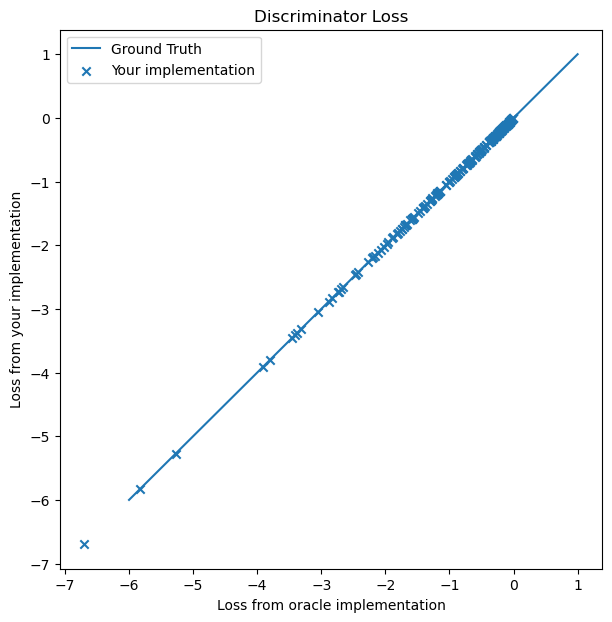

In [52]:
def loss_disc(disc, x_real, x_fake):
    """Compute the discriminator loss for `x_real` and `x_fake` given `disc`
    Args:
    disc: The discriminator
    x_real (ndarray): An array of shape (N,) that contains the real samples
    x_fake (ndarray): An array of shape (N,) that contains the fake samples
    Returns:
    ndarray: The discriminator loss
    """

    # Loss for real data
    label_real = 1
    loss_real = label_real * torch.log(disc.classify(x_real))

    # Loss for fake data
    label_fake = 0
    loss_fake = (1 - label_fake) * torch.log(1 - disc.classify(x_fake))

    return torch.cat([loss_real, loss_fake])

disc = DummyDisc()
gen = DummyGen()

x_real = get_data()
x_fake = gen.sample()

ld = loss_disc(disc, x_real, x_fake)
plotting_ld(ld);

### Generator Loss

Random seed 1 has been set.
Random seed 0 has been set.


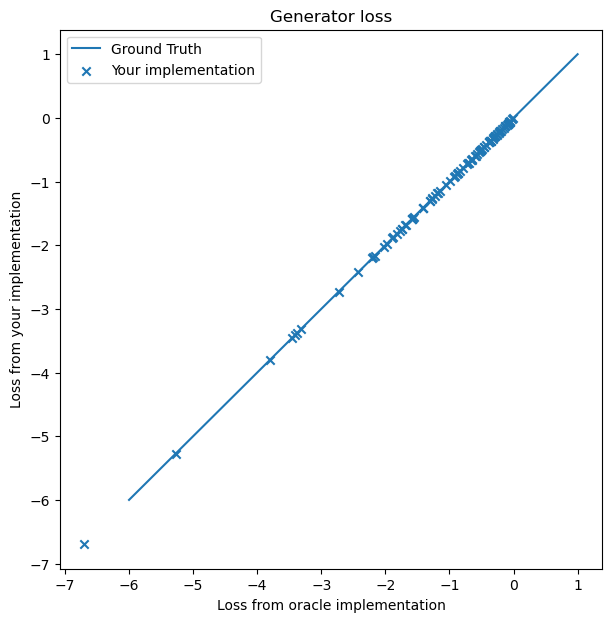

In [53]:
def loss_gen(disc, x_fake):
    """Compute the generator loss for `x_fake` given `disc`

    Args:
    disc: The generator
    x_fake (ndarray): An array of shape (N,) that contains the fake samples

    Returns:
    ndarray: The generator loss
    """
    # Loss for fake data
    label_fake = 1
    loss_fake = label_fake * torch.log(disc.classify(x_fake))

    return loss_fake

disc = DummyDisc()
gen = DummyGen()

x_fake = gen.sample()

lg = loss_gen(disc, x_fake)
plotting_lg(lg);

## Failure Modes of GAN Training

In [54]:
from IPython.display import IFrame
IFrame(src='https://xukai92.github.io/gan_demo/index.html', width=900, height=600)